In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from typing import Tuple 

def window_partition(self, hidden_states: torch.Tensor, window_size: int) -> Tuple[torch.Tensor, Tuple[int, int]]:
    """
    Args:
    Partition into non-overlapping windows with padding if needed.
        hidden_states (tensor): input tokens with [batch_size, height, width, channel]. window_size (int): window
        size.

    Returns:
        windows: windows after partition with [batch_size * num_windows, window_size, window_size, channel].
        (pad_height, pad_width): padded height and width before partition
    """
    batch_size, height, width, channel = hidden_states.shape

    pad_h = (window_size - height % window_size) % window_size
    pad_w = (window_size - width % window_size) % window_size
    hidden_states = F.pad(hidden_states, (0, 0, 0, pad_w, 0, pad_h))
    pad_height, pad_width = height + pad_h, width + pad_w

    hidden_states = hidden_states.reshape(
        batch_size, pad_height // window_size, window_size, pad_width // window_size, window_size, channel
    )
    windows = hidden_states.permute(0, 1, 3, 2, 4, 5).contiguous().reshape(-1, window_size, window_size, channel)
    return windows, (pad_height, pad_width)


def window_unpartition(
      windows: torch.Tensor, window_size: int, padding_shape: Tuple[int, int], original_shape: Tuple[int, int]
   ) -> torch.Tensor:
      """
      Args:
      Window unpartition into original sequences and removing padding.
         hidden_states (tensor):
               input tokens with [batch_size * num_windows, window_size, window_size, channel].
         window_size (int):
               window size.
            padding_shape (Tuple):
                padded height and width (pad_height, pad_width).
            original_shape (Tuple): original height and width (height, width) before padding.

        Returns:
            hidden_states: unpartitioned sequences with [batch_size, height, width, channel].
        """
      pad_height, pad_width = padding_shape
      height, width = original_shape
      batch_size = windows.shape[0] // (pad_height * pad_width // window_size // window_size)
      hidden_states = windows.reshape(
         batch_size, pad_height // window_size, pad_width // window_size, window_size, window_size, -1
      )
      hidden_states = (
         hidden_states.permute(0, 1, 3, 2, 4, 5).contiguous().reshape(batch_size, pad_height, pad_width, -1)
      )

      hidden_states = hidden_states[:, :height, :width, :].contiguous()
      return hidden_states

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [2]:
import torch
from transformers import SamModel, SamProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

/media/caduser/MyBook/chau/miniconda3/envs/chau/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-31): 32 x SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (layer_norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNor

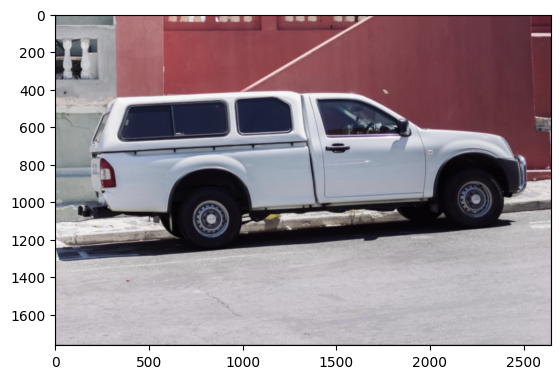

In [ ]:
from PIL import Image
import requests

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
# raw_image = Image.open('images/example1.png').convert("RGB")

plt.imshow(raw_image)

In [5]:
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

/media/caduser/MyBook/chau/miniconda3/envs/chau/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [6]:
input_points = [[[450, 600]]]

In [7]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

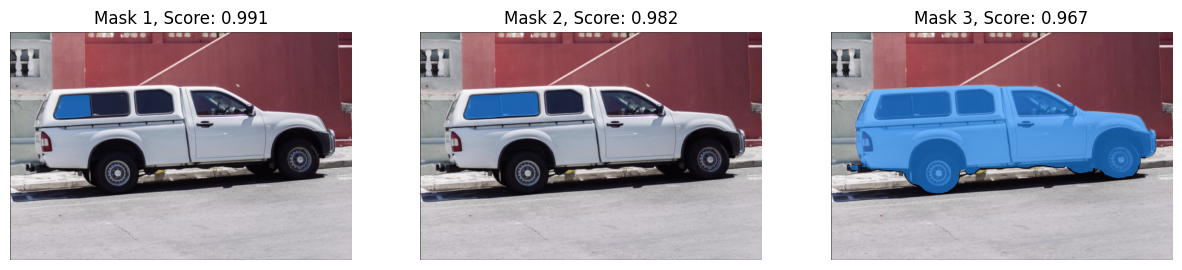

In [8]:
show_masks_on_image(raw_image, masks[0], scores)

In [9]:
import algm

algm.patch.sam(model, selected_layers=[1,5])


In [10]:
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_output(
   pixel_values=inputs["pixel_values"],
   output_hidden_states=True,
   output_attentions=True,
   output_qkv=True
)

/media/caduser/MyBook/chau/miniconda3/envs/chau/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [11]:
def cal_energy(metric:torch.Tensor,margin=0.9):
   metric = F.normalize(metric, p=2, dim=-1)
   sim = metric@metric.transpose(-1,-2)
   energy_score = F.elu((sim - margin), alpha=0).sum(dim=-1)
   # energy_score = (torch.exp(-(((1 - sim)/sigma)**2 * 0.5))).mean(-1) *  1/(sigma*torch.sqrt(torch.tensor(2*torch.pi))) 
   return energy_score

def cal_std(metric:torch.Tensor):
   return metric.std(-1) 

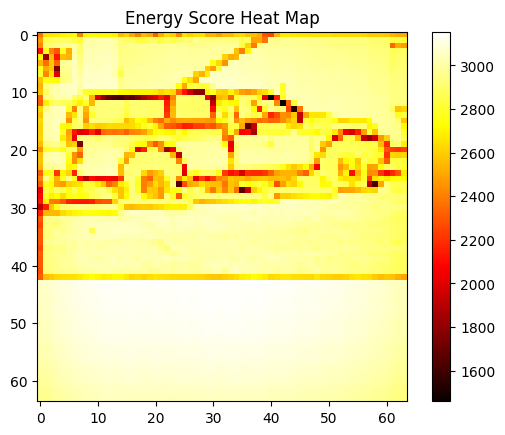

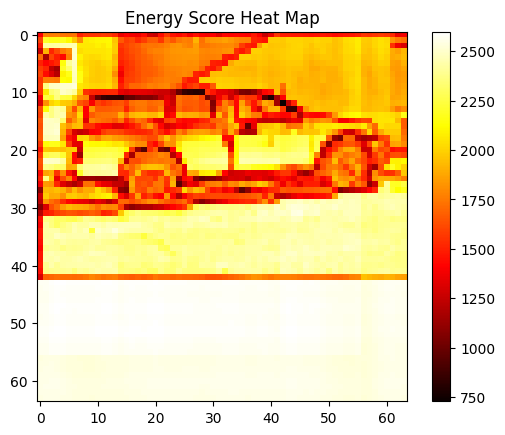

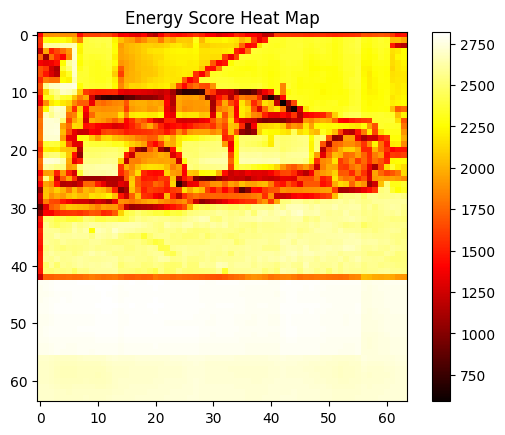

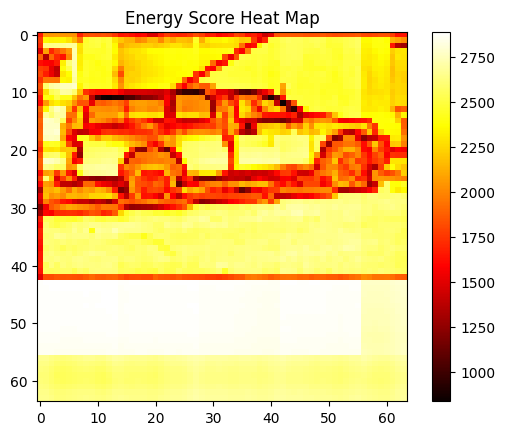

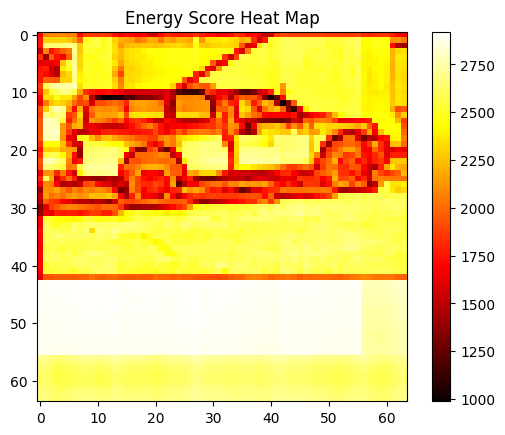

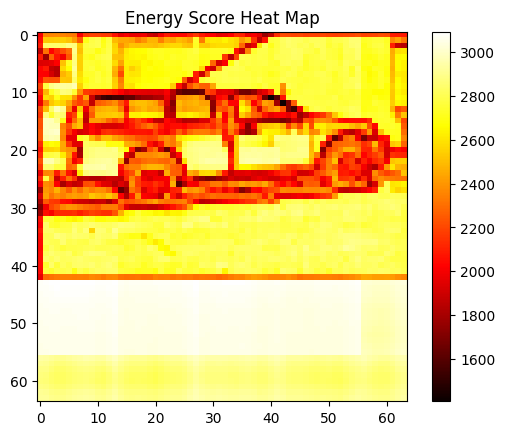

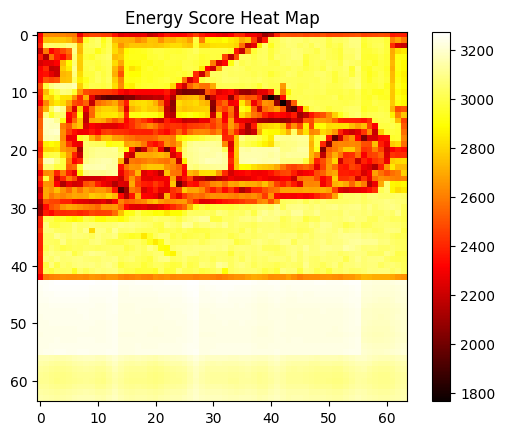

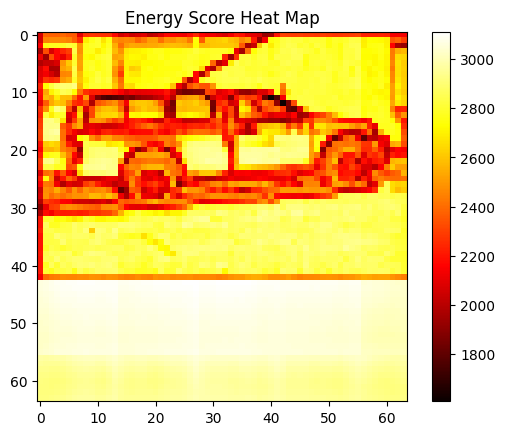

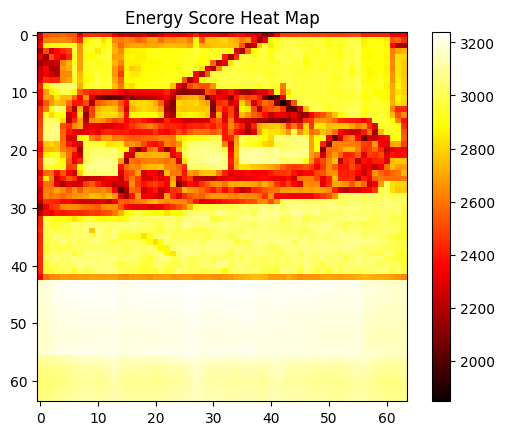

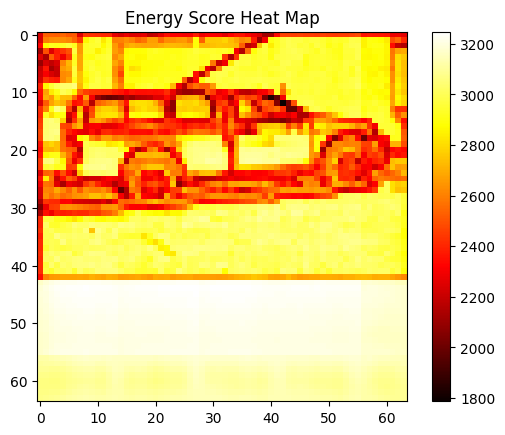

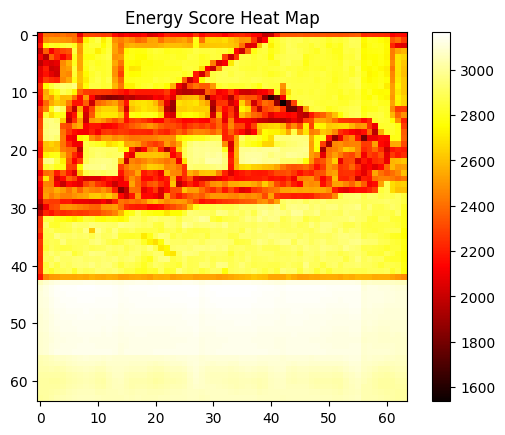

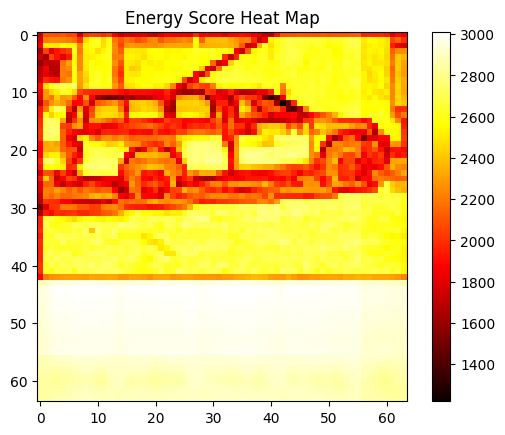

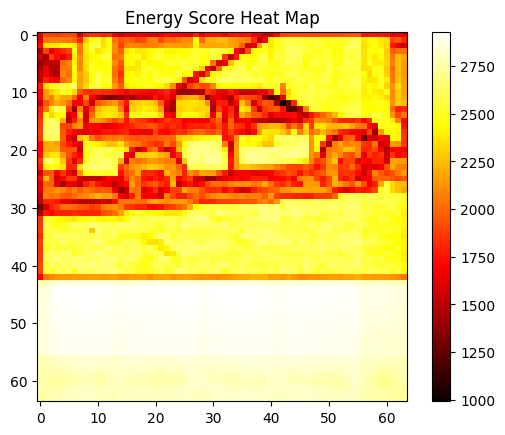

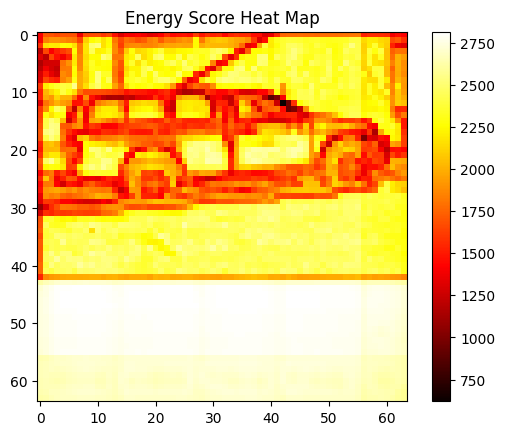

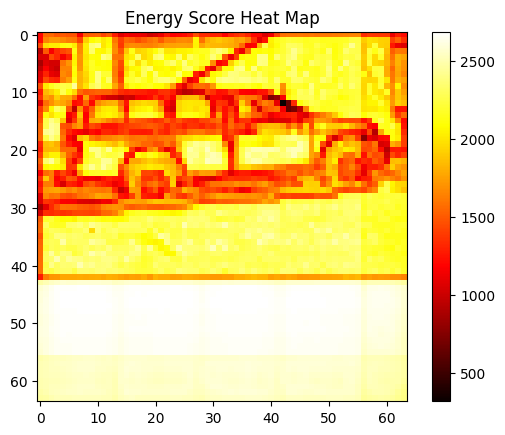

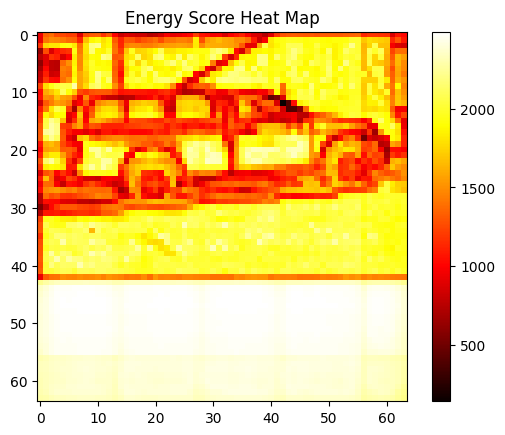

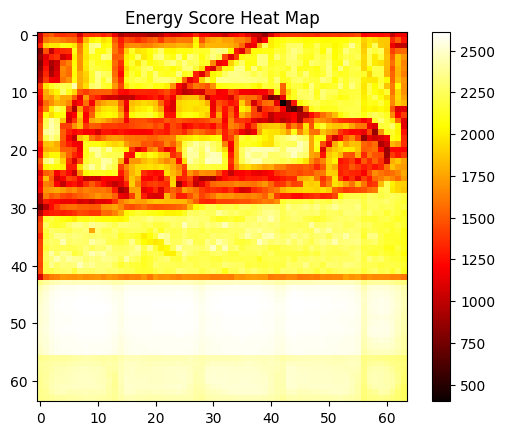

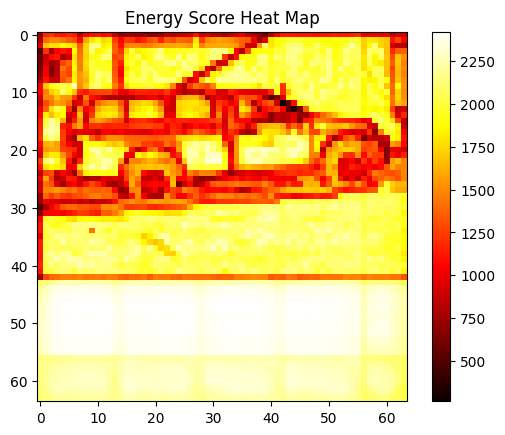

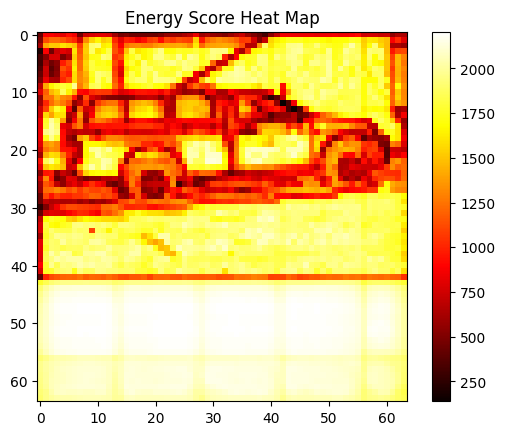

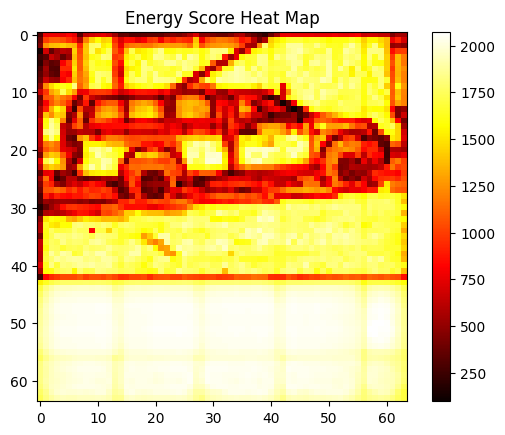

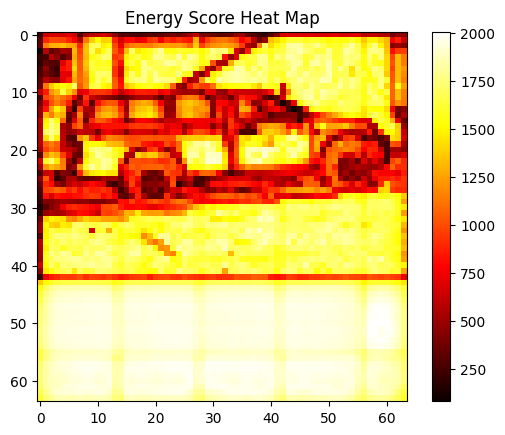

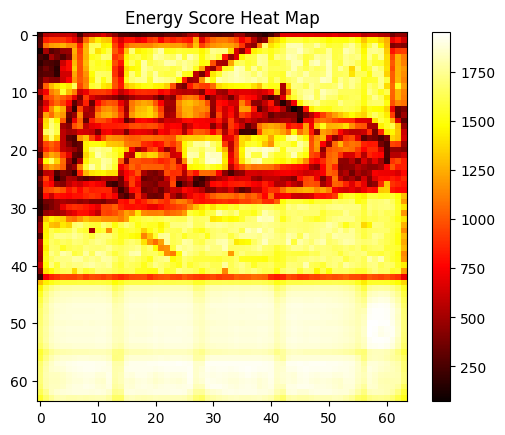

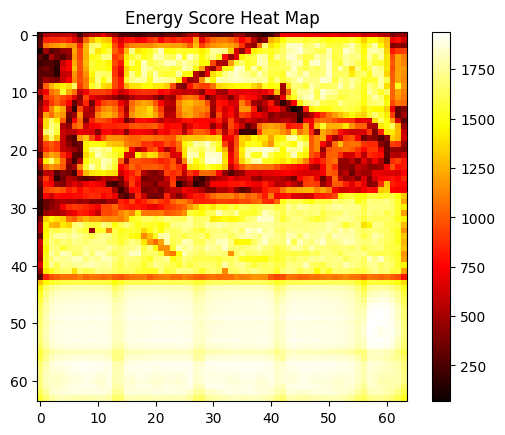

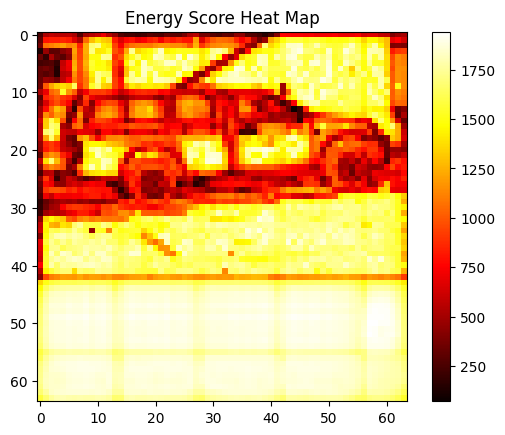

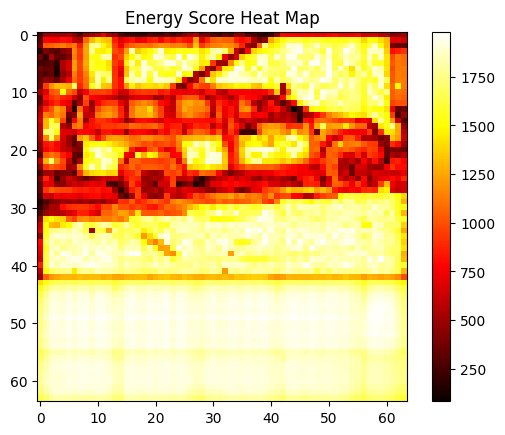

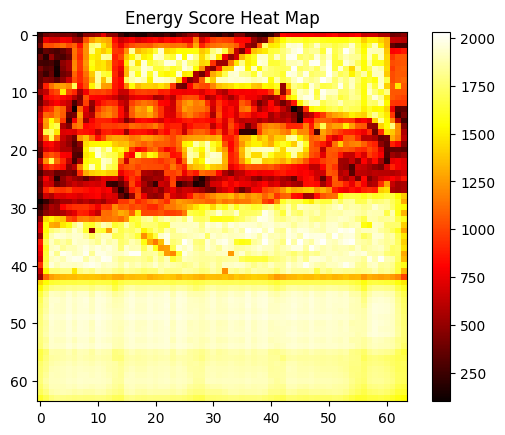

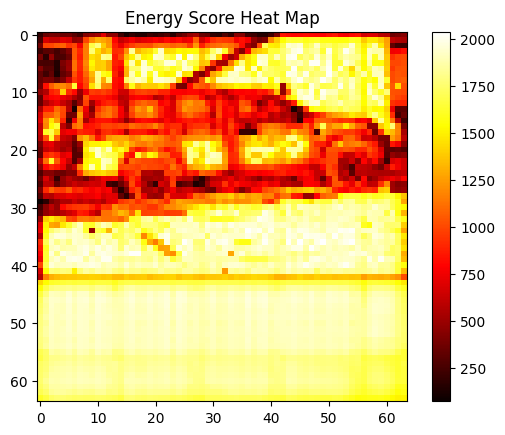

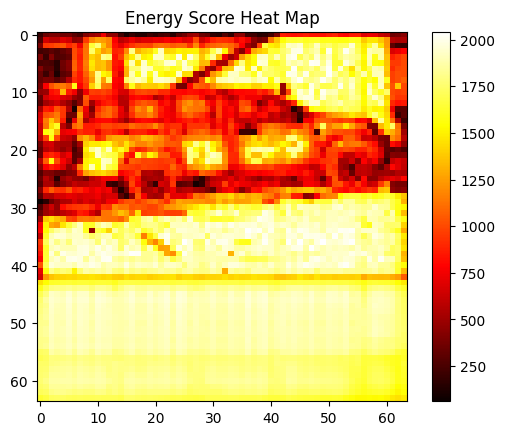

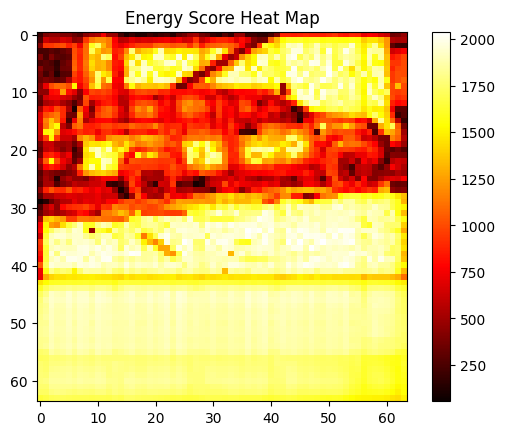

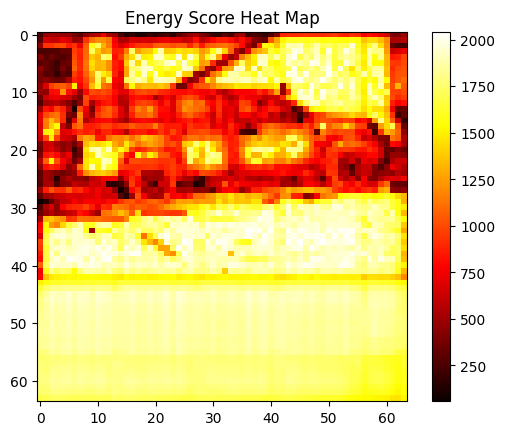

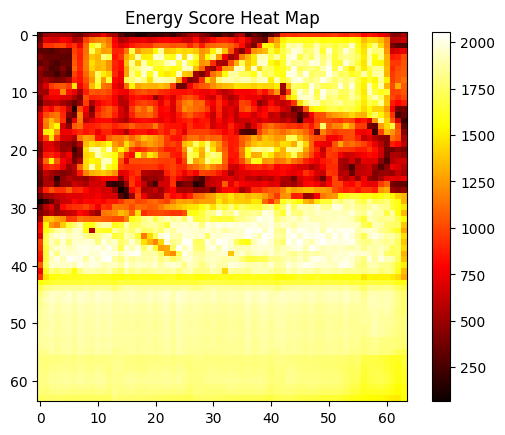

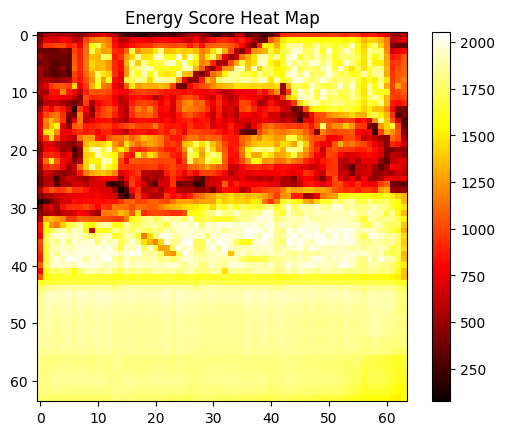

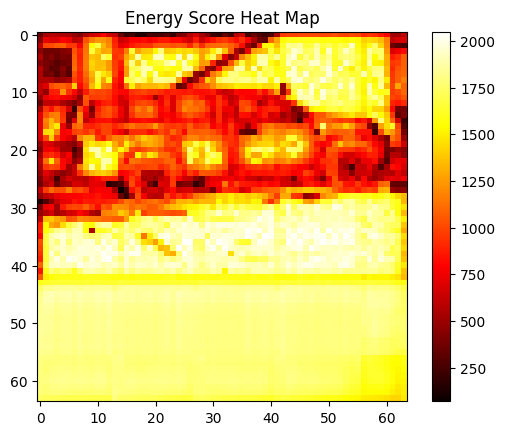

In [12]:
import numpy as np
import matplotlib.pyplot as plt
xs = image_embeddings.hidden_states
def plot_energy(all_hidden_states):
   for hidden_state in all_hidden_states:
      hidden_state = hidden_state.squeeze().view(1, -1, hidden_state.shape[-1])
      energy_score = cal_energy(hidden_state, margin=0.0)

      # Reshape the energy score to 32x32
      reshaped_energy_score = energy_score.view(64, 64).cpu().detach().numpy()

      # Plot the heat map
      plt.imshow(reshaped_energy_score, cmap='hot', interpolation='nearest')
      plt.colorbar()
      plt.title('Energy Score Heat Map')
      plt.show()
   # 
plot_energy(xs)


In [13]:

q = image_embeddings.all_q
k = image_embeddings.all_k
v = image_embeddings.all_v
x = image_embeddings.hidden_states

print(x[0].shape)



torch.Size([1, 64, 64, 1280])


In [14]:
def plot_features(all_data:torch.Tensor, name='hidden_state'):
    for layer_idx in [0,5,7,9,15,20]: # replace with your layer ids
        hidden_state = all_data[layer_idx]
        # energy_score = cal_std(hidden_state).view(-1)
        hidden_state = hidden_state.squeeze().reshape(-1, 1280)
        energy_score = cal_energy(hidden_state, margin=0.25).view(-1)
        # hidden_state = torch.abs(hidden_state).cpu().detach().numpy()
        sorted_indices = torch.argsort(energy_score, dim=0, descending=False)
        print(sorted_indices.device)
        hidden_state = hidden_state[sorted_indices].abs().cpu().detach().numpy()
        # hidden_state = hidden_state.sort(axis=0)[0]

        # Sample 2D tensor (replace this with your actual tensor)

        for idx, tensor in enumerate([hidden_state]):
            # Creating a meshgrid
            tokens, channels = tensor.shape
            x = np.arange(tokens)
            y = np.arange(channels)
            X, Y = np.meshgrid(x, y)
            # Creating a figure and a 3D subplot
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            # Plotting the surface
            surf = ax.plot_surface(X, Y, tensor.T, cmap='coolwarm')

            ax.xaxis.set_tick_params(pad=-5)
            ax.yaxis.set_tick_params(pad=-3)
            ax.zaxis.set_tick_params(pad=-130)

            # Adding labels
            ax.set_xlabel('Token', labelpad=-5)
            ax.set_ylabel('Column', labelpad=-1)
            if layer_idx in [3, 16]:
                ax.zaxis.set_rotate_label(False) 
            if idx == 0:
                save_filename = f'images/{name}/layer{layer_idx}.png'
            else:
                save_filename = f'images/{name}/layer{layer_idx}.png'
            plt.savefig(save_filename, bbox_inches='tight')
            plt.clf()
        

In [15]:
x[0].device

device(type='cuda', index=0)

In [16]:
plot_features(x, name='x')

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [17]:
len(q)

32

In [18]:
plot_features(q, name='q')

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:

plot_features(k, name='k')

cuda:0
cuda:0
cuda:0


cuda:0
cuda:0
cuda:0


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
import torch
a = torch.tensor([1,2], dtype=torch.int8) 
b = torch.tensor([3.23,2.12313], dtype=torch.half) 

In [21]:
a.T @ b

/tmp/ipykernel_37990/2542559275.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  a.T @ b


RuntimeError: dot : expected both vectors to have same dtype, but found Char and Half